Found 1291 images belonging to 4 classes.


/home/oskarem/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.9925 - loss: 0.0303
Test Loss: 0.06358570605516434
Test Accuracy: 0.9860573410987854
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step


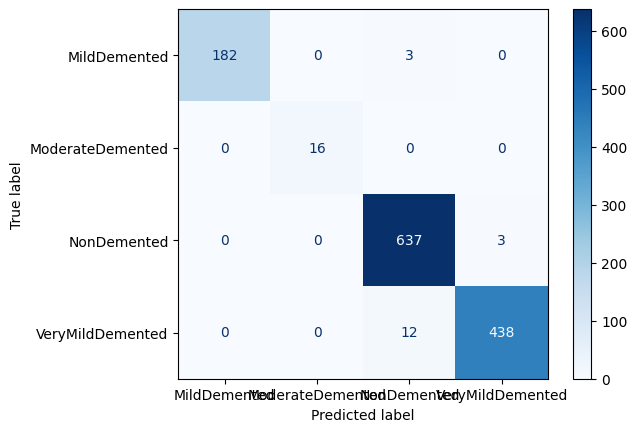

In [15]:
#Test on original dataset

import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf


# Load the saved model
model_path = 'best models/Keras models/final_best_model_Dense_net0.98.keras'  
model = tf.keras.models.load_model(model_path)

# Prepare the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(176, 176),  
    batch_size=16,           
    class_mode='categorical',  
    shuffle=False)            

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

test_loss, test_accuracy = model.evaluate(test_generator)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# display a confusion matrix
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()


Found 1291 images belonging to 4 classes.
Found 1291 images belonging to 4 classes.
Found 1291 images belonging to 4 classes.


/home/oskarem/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step
Ensemble Model Accuracy: 0.9891556932610379


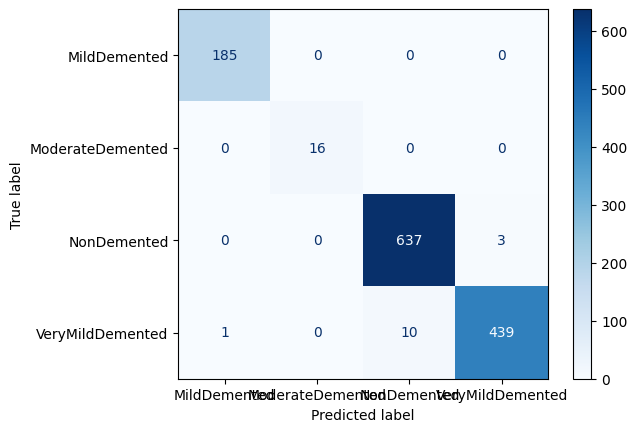

In [4]:
#Test voting system
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # This line prevents TensorFlow from using GPU

def sobel_edge_detection(image):
    import tensorflow as tf
    # Add a batch dimension
    image = tf.expand_dims(image, axis=0)
    image = tf.image.rgb_to_grayscale(image)

    sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
    sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
    sobel_x_filter = tf.reshape(sobel_x, [3, 3, 1, 1])
    sobel_y_filter = tf.reshape(sobel_y, [3, 3, 1, 1])

    Gx = tf.nn.conv2d(input=image, filters=sobel_x_filter, strides=[1, 1, 1, 1], padding='SAME')
    Gy = tf.nn.conv2d(input=image, filters=sobel_y_filter, strides=[1, 1, 1, 1], padding='SAME')

    G = tf.sqrt(tf.square(Gx) + tf.square(Gy))
    G = tf.squeeze(G, axis=0)  # Remove the batch dimension

    # Resize image to match the model's expected input dimensions (Updated to 176, 208)
    G = tf.image.resize(G, [176, 208])

    # Replicate grayscale to 3 channels
    G = tf.repeat(G, 3, axis=-1)
    
    return G.numpy()  # Ensure this returns a NumPy array


# Initialize the ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
sobel_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sobel_edge_detection)

# Setup generators with correct target_size
target_size = (176, 208)
target_size2 = (176, 176)
batch_size = 16

non_augmented_generator = test_datagen.flow_from_directory(
    'test',  # Update path as necessary
    target_size=target_size2,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

non_augmented_generator2 = test_datagen.flow_from_directory(
    'test',  # Update path as necessary
    target_size=target_size2,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

sobel_generator = sobel_datagen.flow_from_directory(
    'test',  # Update path as necessary
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



# Load Models
non_augmented_model = load_model('best models/Keras models/final_best_model_Dense_net0.98.keras')
non_augmented_model2 = load_model('best models/Keras models/final_best_model_ResNetacc93.keras')
#non_augmented_model3 = load_model('best models/Keras models/checkpoint-95-0.69_CNN_normal.keras')
#sobel_model = load_model('best models/Keras models/model_1640_ResNet_sobel_augentations_0.7817.keras')


# Predict using both models after adjusting the Sobel preprocessing function
non_augmented_predictions = non_augmented_model.predict(
    non_augmented_generator,
    steps=int(np.ceil(non_augmented_generator.samples / batch_size))
)

non_augmented_predictions2 = non_augmented_model2.predict(
    non_augmented_generator2,
    steps=int(np.ceil(non_augmented_generator2.samples / batch_size))
)

#non_augmented_predictions3 = non_augmented_model3.predict(
#    non_augmented_generator,
#    steps=int(np.ceil(non_augmented_generator.samples / batch_size))
#)

#sobel_predictions = sobel_model.predict(
#    sobel_generator,
#    steps=int(np.ceil(sobel_generator.samples / batch_size))
#)

# Combine predictions using simple averaging
combined_predictions = (non_augmented_predictions + non_augmented_predictions2) / 2 # + sobel_predictions  + non_augmented_predictions3) / 4
predicted_classes = np.argmax(combined_predictions, axis=1)

# Check accuracy
true_classes = non_augmented_generator.classes
accuracy = np.mean(predicted_classes == true_classes)
print(f"Ensemble Model Accuracy: {accuracy}")

# Display confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=non_augmented_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()


Found 1291 images belonging to 4 classes.


/home/oskarem/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7849 - loss: 2.0188
Test loss: 2.1168673038482666, Test accuracy: 0.7800154685974121
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step


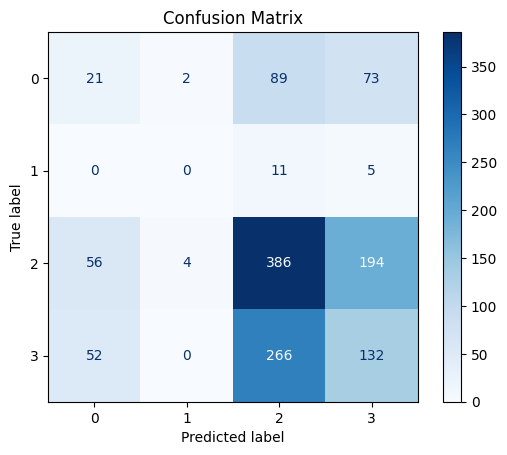

81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7937 - loss: 1.8682
Test loss: 2.1168675422668457, Test accuracy: 0.7800154685974121


In [8]:
#Test sobel augmentation alone
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import wandb
from transformers import AutoImageProcessor, ResNetForImageClassification
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def setup_wandb():
    wandb.init(project="computer_vision", config={
        "learning_rate": 0.001,
        "architecture": "ResNet50",
        "dataset": "alzheimer",
        "epochs": 30,
        "batch_size": 16,
        "input_shape": (176, 176, 3),  # Updated input shape
        "num_classes": 4
    })
    return wandb.config

config = setup_wandb()

def sobel_edge_detection(image):
    """
    Applies the Sobel edge detection algorithm to an input image.

    Args:
    image: A tensor of shape (height, width, channels), representing the input image.

    Returns:
    A tensor of the same shape as the input, containing the edge-detected image.
    """
    # Add a batch dimension if it's missing
    if len(image.shape) == 3:
        image = tf.expand_dims(image, axis=0)

    # Define Sobel filters for x and y directions.
    sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
    sobel_x_filter = tf.reshape(sobel_x, [3, 3, 1, 1])
    sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
    sobel_y_filter = tf.reshape(sobel_y, [3, 3, 1, 1])

    # Convert the image to grayscale if it has more than one channel.
    if image.shape[-1] > 1:
        image = tf.image.rgb_to_grayscale(image)

    # Filter the image with Sobel kernels.
    Gx = tf.nn.conv2d(input=image, filters=sobel_x_filter, strides=[1, 1, 1, 1], padding='SAME')
    Gy = tf.nn.conv2d(input=image, filters=sobel_y_filter, strides=[1, 1, 1, 1], padding='SAME')

    # Compute the magnitude of the gradients.
    G = tf.sqrt(tf.square(Gx) + tf.square(Gy))
    G = tf.squeeze(G, axis=0)  # Remove the batch dimension.

    return G

def create_resnet_model(config):
    # Load the ResNet50 model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=config.input_shape)
    
    # Freezing the layers except the last 10 layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(config.num_classes, activation='softmax')(x)
    
    # Creating the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Define the preprocessing function for Sobel edge detection
def custom_preprocessing_function(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [176, 208])  # Resize to match model input
    return sobel_edge_detection(image)


# Path to your saved model
model_path = 'best models/Keras models/model_1640_ResNet_sobel_augentations_0.7817.keras'

# Load the entire model including its weights and architecture
model = load_model(model_path)


# Create a data generator for testing with Sobel edge detection
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=custom_preprocessing_function)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(176, 208),  # Ensure the size matches the expected input size of the model
    batch_size=config.batch_size,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

# Get the number of images in the test set
num_of_test_samples = test_generator.samples

# Get the predictions from the model using the generator
# Make sure to convert the number of steps to an integer
predictions = model.predict(test_generator, steps=int(np.ceil(num_of_test_samples / config.batch_size)))

# Convert predictions classes to one hot vectors 
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=range(config.num_classes))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(config.num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the evaluation results
test_loss, test_accuracy = model.evaluate(test_generator, steps=int(np.ceil(num_of_test_samples / config.batch_size)))
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

